# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$$ w_{new} = w_{old} - {\alpha}({\nabla}_{w}(L(w_{old})) $$

$$ L(w) = \frac{1}{N}\left[\sum_i (y_i - (x_i, w)) ^ 2 \right] + \frac{1}{C}R(w) $$

$$ R(w) = w ^ 2 $$

$$ {\nabla}_w(L(w)) = \frac{2}{N}  {\sum_i}x_i\bigl((x_i,w) - y_i\bigr) + \frac{2}{C}w $$

$$ w_{new} = \bigl(1 - \frac{2\alpha}{C}\bigr)w_{old} - \frac{2\alpha}{N}  {\sum_i}x_i\bigl((x_i,w) - y_i\bigr) $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ w_{new} = w_{old} - {\alpha}({\nabla}_{w}(L(w_{old})) $$

$$ L(w) = -\frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w) = $$

$$-\frac{1}{N}\left[\sum_i y_i \log \sigma((x_i,w)) + ( 1 - y_i) \log (1 - \sigma((x_i,w))) \right] +  \frac{1}{C}R(w)$$

$$ L(w) = -\frac{1}{N}(y, \log \sigma(Xw^T)) + ((\vec{1} - y), \log \sigma(\vec{1} - Xw^T)) + \frac{1}{C}R(w) $$

$$  R(w) = w ^ 2 $$

$$\sigma((x_i,w)) = \frac{1}{1 + \exp(-(x_i,w))} = k$$



$$\nabla_w\sigma((x_i,w)) = \frac{-x_i\exp(-(x_i,w))}{\bigl(1 + \exp(-(x_i,w))\bigr)^2} = m$$

$$ \nabla_w(L(w) - R(w)) = -\frac{1}{N}\sum_i \left[y_i\frac{m}{k} + (y_i - 1) \frac{m}{1-k} \right] = $$

$$  = \frac{1}{N}\sum_ix_i\left[ \frac{-y_i\exp(-(x_i,w))}{1 + \exp(-(x_i,w))} + \frac{1 - y_i}{1 + \exp(-(x_i,w))} \right] = $$

$$  = \frac{1}{N}\sum_ix_i \bigl[ \frac{1}{1 + \exp(-(x_i,w))} - y_i\bigr] = \frac{1}{N}\sum_ix_i \bigl[ \sigma((x_i,w)) - y_i\bigr] $$

$$ w_{new} = \bigl(1 - \frac{2\alpha}{C}\bigr)w_{old} - \frac{\alpha}{N}\sum_ix_i \bigl[ \sigma((x_i,w)) - y_i\bigr] $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

$$ Q(w) = \frac{1}{N}(Xw - y)^T(Xw - y) $$

$$\nabla_wQ(w) = 2X^TXw − 2X^Ty $$

$$ w = X^{-1}y $$

$$\nabla^2_w = 2X^TX$$

$$ H = \det(2X^TX) $$

$ rank(X) $ равен числу столбцов матрицы $X => $ матрица $ X^TX $ имеем максимальный ранг $ => H \neq 0$

И так как для любой матрицы $A$ матрица $A^TA$ будет положительно определена, то $H > 0 => $ имеем минимум функции в точке $ w = X^{-1}y $

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$p(y_i = 1|x_i) = p, p(y_i = 0|x_i) = q = 1 - p$

$ E(L|x_i) = -p\log(a) - (1 - p)\log(1 - a)$

$$\frac{\partial E}{\partial{a}} = -\frac{p}{a} + \frac{1 - p}{1 - a} = 0$$

$$p(a - 1) + a(1 - p) = 0$$

$a - p = 0 => a = p $ - точка минимума ($a < p => \frac{\partial E}{\partial{a}} < 0, a > p => \frac{\partial E}{\partial{a}} > 0$)

Вспоминаем, что $p = p(y_i = 1|x_i)$ - чтд.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Нет, так как $w_0$ отвечает за смещение нашей гиперплоскости, которое может быть любое, поэтому нам не надо его минимизировать

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [1]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [2]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [3]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [4]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
import numpy as np

def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    s = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(s)
    X = X[s]
    y = y[s]
    for i in range(0, X.shape[0] - batch_size + 1, batch_size):
        X_batch = X[i: i + batch_size]
        y_batch = y[i: i + batch_size]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [6]:
x = np.arange(27).reshape((9, 3))
y = np.arange(9).reshape((9, 1))
gen = batch_generator(x, y, batch_size=3)
for i, res in enumerate(gen):
    x_b, y_b = res
    print(x_b, y_b, sep = '\n', end='\n\n')

[[15 16 17]
 [12 13 14]
 [ 6  7  8]]
[[5]
 [4]
 [2]]

[[18 19 20]
 [ 9 10 11]
 [ 3  4  5]]
[[6]
 [3]
 [1]]

[[21 22 23]
 [24 25 26]
 [ 0  1  2]]
[[7]
 [8]
 [0]]



In [3]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    sigm_value_x = 1 / (1 + np.exp(-x))
    
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        w = self.weights
        N = X_batch.shape[0]
        if self.model_type == 'lin_reg':
            loss = 1 / N * np.linalg.norm(y_batch - np.dot(X_batch, w)) ** 2
        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, w))
            loss = -1 / N * (y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a))
            
            
        reg = 1 / self.C * np.dot(w, w)
        
        loss += reg
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        w = np.asarray(self.weights)
        N = X_batch.shape[0]
        if self.model_type == 'lin_reg':
            loss_grad = 2 / N * np.dot(np.dot(X_batch, w) - y_batch, X_batch)
        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, w))
            loss_grad = 1 / N * np.dot(a - y_batch, X_batch)
            
        
        reg = 2 / self.C * w
        #print("reg = {}\n\n".format(reg))
        loss_grad += reg
        
        
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        return loss_grad
    
    def update_weights(self, new_grad):
        #print("weights = {}\n\nnew_grad={}\n\n\n".format(self.weights, new_grad))
        self.weights -= self.alpha * new_grad
        
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        if len(X.shape) > 1:
            self.weights = np.random.normal(0, 1, X.shape[1] + 1)
        else:
            self.weights = np.random.normal(0, 1, 2)
        
        o = np.ones((X.shape[0], 1))
        X = np.concatenate((o, X), axis=1)
            
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                # batch_loss = self.calc_loss(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if self.model_type == 'lin_reg':
            predict = np.dot(np.concatenate((np.ones((X.shape[0], 1)), X), axis=1), self.weights)
        elif self.model_type == 'log_reg':
            predict = sigmoid(np.dot(np.concatenate((np.ones((X.shape[0], 1)), X), axis=1), self.weights))
            
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return predict

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [13]:
def plot_decision_boundary(clf, w=0):
    ## Your code Here
    w = clf.weights
    a = w[0]
    b = w[1]
    c = w[2]
    ## a + bx + cy = 0
    ## y = (-b * x - a) / c 
    x = np.linspace(-4, 8, 50)
    y = (-b * x - a) / c
#     y = a * x + b
    plt.plot(x, y)

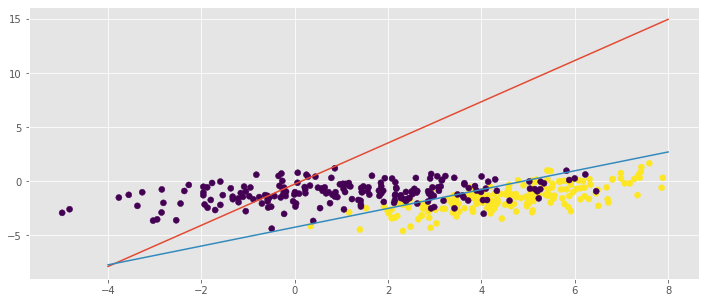

In [15]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', C=1, max_epoch=100, alpha=0.01, batch_size=2)
clf_log = MySGDClassifier(batch_generator, model_type='log_reg', C=1000, max_epoch=100)
clf_lin.fit(X, y)
clf_log.fit(X, y)
plot_decision_boundary(clf_lin)
plot_decision_boundary(clf_log)

plt.scatter(X[:,0], X[:,1],  c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [17]:
from sklearn.datasets import make_classification

In [18]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

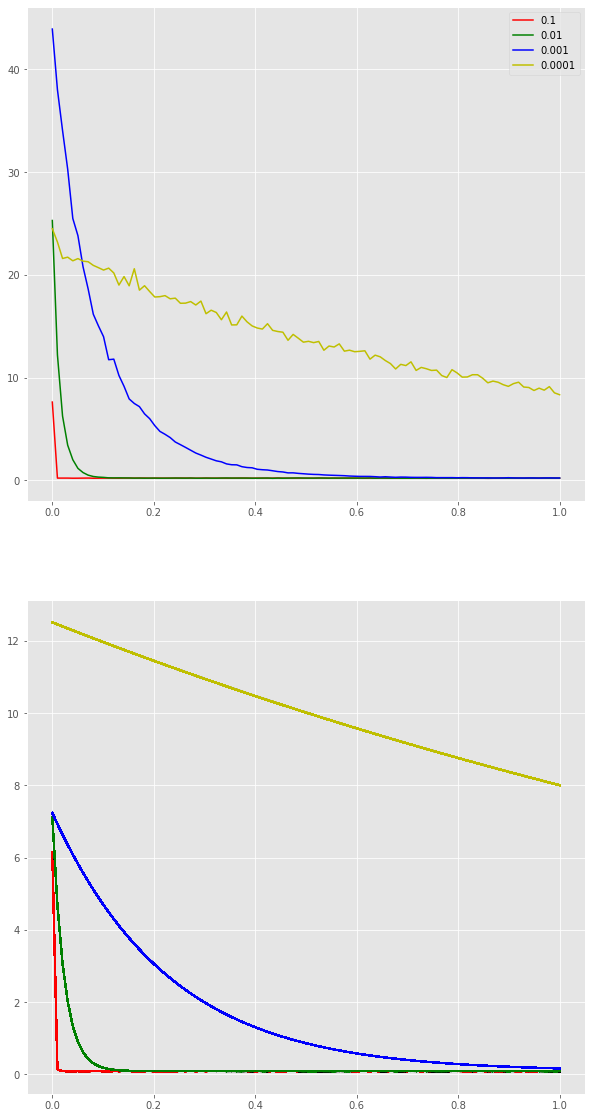

In [19]:
## Your Code Here
fig, axis = plt.subplots(2, figsize=(10, 20))
samples = X.shape[0]
N = 100
length = 20
x = [0.1, 0.01, 0.001, 0.0001]
i = 0
colors = ['r', 'g', 'b', 'y']
for alpha in x:
    bs = samples // N
    clf = MySGDClassifier(batch_generator, alpha=alpha, batch_size=bs)
    res = clf.fit(X, y)
    loss = np.asarray(res.errors_log['loss'])
    axis[0].plot(np.linspace(0, 1, N), loss[::10], color=colors[i])
    
    clf = MySGDClassifier(batch_generator, alpha=alpha, batch_size=bs, model_type='log_reg')
    res = clf.fit(X, y)
    loss = np.asarray(res.errors_log['loss'])
    axis[1].plot(np.linspace(0, 1, N), loss[::10], color=colors[i])
    i += 1
    
axis[0].legend(x)

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Оптимальные значения параметра $\alpha$ - 0.1, 0.01. При $\alpha$ = 0.001, 0.0001 - сходимость слишком медленная. Значение параметра обратно пропорционально скорости сходимости

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: overflow encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


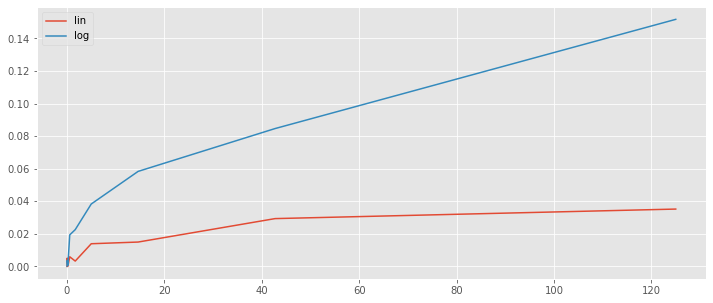

In [20]:
## Your Code Here
Cs = np.logspace(3, -3, 10, base=5)

X = X[:3000]
y = y[:3000]

log = np.zeros(10)
lin = np.zeros(10)
i = 0
for C in Cs:
    
    clf = MySGDClassifier(batch_generator, C, max_epoch=10)
    clf.fit(X, y)
    lin[i] = abs(clf.weights[1:].mean())
    
    clf = MySGDClassifier(batch_generator, C, model_type='log_reg', max_epoch=10)
    clf.fit(X, y)
    log[i] = abs(clf.weights[1:].mean())
    i += 1
    
plt.plot(Cs, lin)
plt.plot(Cs, log)
plt.legend(["lin", "log"])

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Доволен, сильно)

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [4]:
import pandas as pd
title_data = pd.read_csv('docs_titles.tsv', sep='\t', encoding='utf-8', lineterminator='\n')
train_groups = pd.read_csv('train_groups.csv')
test_groups = pd.read_csv('test_groups.csv')

In [45]:
title_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 2 columns):
doc_id    27950 non-null int64
title     27919 non-null object
dtypes: int64(1), object(1)
memory usage: 436.8+ KB


In [5]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))

28026


In [6]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))
    
    
    
    

test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc_test = test_data.iloc[i]
    doc_group_test = new_doc_test['group_id']
    doc_id_test = new_doc_test['doc_id']
    pair_id = new_doc_test['pair_id']
    title_test = doc_to_title[doc_id]
    if doc_group_test not in testgroups_titledata:
        testgroups_titledata[doc_group_test] = []
    testgroups_titledata[doc_group_test].append((doc_id_test, title_test, pair_id))

In [8]:
import re
train_groups_words = {r + 1: [] for r in range(np.unique(train_data['group_id'].values).shape[0])}
words_freq = {}

train_groups_ones = []
for doc in traingroups_titledata:
    gr = traingroups_titledata[doc]
    for element in gr:
        if(element[2] == 1):
            words = element[1].split(' ')
            for key, _ in enumerate(words):
                words[key] = words[key].lower()
                words[key] = re.sub('[\W]', '', words[key])
                if(len(words[key]) < 3):
                    words.remove(words[key])
                    
            train_groups_words[doc] += words
            
for doc in testgroups_titledata:
    gr = testgroups_titledata[doc]
    for element in gr:
        words = element[1].split(' ')
        for key, _ in enumerate(words):
            words[key] = words[key].lower()
            words[key] = re.sub('[\W]', '', words[key])
            if(len(words[key]) < 3):
                words.remove(words[key])
            

train_groups_ones_words = train_groups_words
def get_words_count_vector(groups_titledata, data):
    train_groups_words = [[0 for i in range(len(traingroups_titledata))] for i in range(len(data))]

    k = 0
    for doc in groups_titledata:
        print(doc, end=' ')
        gr = groups_titledata[doc]
        for element in gr:
            words = element[1].split(' ')
            for key, word in enumerate(words):
                word = word.lower()
                words[key] = words[key].lower()
                words[key] = re.sub('[\W]', '', word)
                word = words[key]
                if(len(word) < 3):
                    words.remove(word)


            for num in train_groups_ones_words:
                grs = train_groups_ones_words[num]
                count = 0

                for word in words:
                    if word in grs:
                        count += 1
                train_groups_words[k][num - 1] = count
            k += 1
    return train_groups_words



In [9]:
train_groups_words = get_words_count_vector(traingroups_titledata, train_data)
train_groups_words = np.array(train_groups_words)
train_groups_words.shape

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 

(11690, 129)

In [10]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = title.strip().split()
        for key, word in enumerate(words):
            words[key] = words[key].lower()
            words[key] = re.sub('[\W]', '', words[key])
            if(len(words[key]) < 3):
                words.remove(words[key])
        words = set(words)
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
X_train = np.concatenate((X_train, groups_train[:, np.newaxis], train_groups_words), axis=1)



In [11]:
print (X_train.shape, y_train.shape, groups_train.shape, train_groups_words.shape)

(11690, 145) (11690,) (11690,) (11690, 129)


In [26]:
np.unique(groups_train).shape[0]

129

Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [12]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [139]:
import time

scaler = StandardScaler()
X = scaler.fit_transform(X_train)

batch_sizes = np.logspace(3, 9, 7, base=2).astype(int)
epochs = 100
for bs in batch_sizes:
    start_time = time.time()
    clf = MySGDClassifier(batch_generator, max_epoch=epochs, model_type='log_reg', batch_size=bs)
    clf.fit(X, y_train)
    print("Batch size = {}; Time = {}".format(bs, time.time() - start_time))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


Batch size = 8; Time = 6.725015640258789
Batch size = 16; Time = 4.008276700973511
Batch size = 32; Time = 2.6309974193573
Batch size = 64; Time = 3.150463342666626
Batch size = 128; Time = 2.1994125843048096
Batch size = 256; Time = 1.730743169784546
Batch size = 512; Time = 1.5606951713562012


In [13]:

scaler = StandardScaler()
X = scaler.fit_transform(X_train)
BS = 256

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [14]:
from sklearn.metrics import roc_auc_score

def split(X, y, groups, valid_ratio=0.5):
    g = np.unique(groups)
    train_num = int(g.shape[0] * (1 - valid_ratio))
    np.random.shuffle(g)
    g_train = g[:train_num]
    g_valid = g[train_num:]
    groups_train = groups[np.isin(groups, g_train)].argsort()
    groups_valid = groups[np.isin(groups, g_valid)].argsort()
    X_train = X[np.isin(groups, g_train)][groups_train]
    X_valid = X[np.isin(groups, g_valid)][groups_valid]
    y_train = y[np.isin(groups, g_train)][groups_train]
    y_valid = y[np.isin(groups, g_valid)][groups_valid]
    return X_train, X_valid, y_train, y_valid

def score(clf, X, y):
    y_pred = clf.predict(X)
    if np.isnan(y_pred).any():
        return 0.5
    sc = roc_auc_score(y, y_pred)
    return sc

def cross_val_score(clf, X, y, g, samples=3):
    scores = []
    for i in range(samples):
        Xt, Xv, yt, yv = split(X, y, g)
        clf.fit(Xt, yt)
        scores.append(score(clf, Xv, yv))
    scores = np.array(scores)
    return np.mean(scores)

alphas = np.logspace(2, 4, 3, base=0.1)
Cs = np.logspace(-1, 5, 7, 10)
epochs = np.logspace(1, 5, 5, base=2).astype(int)
models = ['lin_reg', 'log_reg']
max_score = 0.5
for max_epoch in epochs:
    for C in Cs:
        for a in alphas:
            for model in models:
                clf = MySGDClassifier(batch_generator, C=C, alpha=a, model_type=model, max_epoch=max_epoch, batch_size=BS)
                sc = cross_val_score(clf, X, y_train, groups_train)
                print("epochs = {}, C = {}, a = {}, model = {}, score = {}".
                      format(max_epoch, C, a, model, sc))
                if sc != np.nan and sc > max_score:
                    max_score = sc
                    best_params = (sc, max_epoch, C, a, model)
best_params

epochs = 2, C = 0.1, a = 0.010000000000000002, model = lin_reg, score = 0.8227108318231857
epochs = 2, C = 0.1, a = 0.010000000000000002, model = log_reg, score = 0.8195667634608713


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


epochs = 2, C = 0.1, a = 0.0010000000000000002, model = lin_reg, score = 0.5130396479753448
epochs = 2, C = 0.1, a = 0.0010000000000000002, model = log_reg, score = 0.510885577334001


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 0.1, a = 0.00010000000000000002, model = lin_reg, score = 0.6082563760237739
epochs = 2, C = 0.1, a = 0.00010000000000000002, model = log_reg, score = 0.5273342339633295


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 1.0, a = 0.010000000000000002, model = lin_reg, score = 0.6067174004135104
epochs = 2, C = 1.0, a = 0.010000000000000002, model = log_reg, score = 0.674653403981607


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 1.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5067958523320285
epochs = 2, C = 1.0, a = 0.0010000000000000002, model = log_reg, score = 0.549401056699926


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 1.0, a = 0.00010000000000000002, model = lin_reg, score = 0.48364047705172
epochs = 2, C = 1.0, a = 0.00010000000000000002, model = log_reg, score = 0.5714484106969983


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 10.0, a = 0.010000000000000002, model = lin_reg, score = 0.4774564323538719
epochs = 2, C = 10.0, a = 0.010000000000000002, model = log_reg, score = 0.5094130788011134


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 10.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5531842557010292
epochs = 2, C = 10.0, a = 0.0010000000000000002, model = log_reg, score = 0.4738990793553144


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 10.0, a = 0.00010000000000000002, model = lin_reg, score = 0.432931168896292
epochs = 2, C = 10.0, a = 0.00010000000000000002, model = log_reg, score = 0.5304110378865253


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 100.0, a = 0.010000000000000002, model = lin_reg, score = 0.5162113024461579
epochs = 2, C = 100.0, a = 0.010000000000000002, model = log_reg, score = 0.6770925430215619


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 100.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5193327328179095
epochs = 2, C = 100.0, a = 0.0010000000000000002, model = log_reg, score = 0.387296249981732

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply



epochs = 2, C = 100.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4629737758837811


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 100.0, a = 0.00010000000000000002, model = log_reg, score = 0.4555203348261457
epochs = 2, C = 1000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5667252636978626


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 1000.0, a = 0.010000000000000002, model = log_reg, score = 0.5863898045194703
epochs = 2, C = 1000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5406232935895555


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 1000.0, a = 0.0010000000000000002, model = log_reg, score = 0.6118222910690589
epochs = 2, C = 1000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4941227600503952


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 1000.0, a = 0.00010000000000000002, model = log_reg, score = 0.49335800319547696
epochs = 2, C = 10000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5501178326143403
epochs = 2, C = 10000.0, a = 0.010000000000000002, model = log_reg, score = 0.6346082578420981

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply



epochs = 2, C = 10000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.471260276745687


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 10000.0, a = 0.0010000000000000002, model = log_reg, score = 0.4263919266723155
epochs = 2, C = 10000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4284042597342261


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 10000.0, a = 0.00010000000000000002, model = log_reg, score = 0.4632895288203332
epochs = 2, C = 100000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5809644920129999
epochs = 2, C = 100000.0, a = 0.010000000000000002, model = log_reg, score = 0.5609228165290997


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 100000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5165689901545929
epochs = 2, C = 100000.0, a = 0.0010000000000000002, model = log_reg, score = 0.4645571270283182


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 2, C = 100000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4294534545165496
epochs = 2, C = 100000.0, a = 0.00010000000000000002, model = log_reg, score = 0.40534391022885047


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 0.1, a = 0.010000000000000002, model = lin_reg, score = 0.8184525206299113


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 0.1, a = 0.010000000000000002, model = log_reg, score = 0.8044044693249116
epochs = 4, C = 0.1, a = 0.0010000000000000002, model = lin_reg, score = 0.5744778900308408


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 0.1, a = 0.0010000000000000002, model = log_reg, score = 0.4975668634387614
epochs = 4, C = 0.1, a = 0.00010000000000000002, model = lin_reg, score = 0.5013456332720704


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 0.1, a = 0.00010000000000000002, model = log_reg, score = 0.5578196121558913
epochs = 4, C = 1.0, a = 0.010000000000000002, model = lin_reg, score = 0.6498975627981304


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 1.0, a = 0.010000000000000002, model = log_reg, score = 0.7447393407126789
epochs = 4, C = 1.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5242889015551794


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 1.0, a = 0.0010000000000000002, model = log_reg, score = 0.4224179716818471
epochs = 4, C = 1.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5982686813588659


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 1.0, a = 0.00010000000000000002, model = log_reg, score = 0.5134191212088348
epochs = 4, C = 10.0, a = 0.010000000000000002, model = lin_reg, score = 0.580080181231696


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 10.0, a = 0.010000000000000002, model = log_reg, score = 0.6212772421345653
epochs = 4, C = 10.0, a = 0.0010000000000000002, model = lin_reg, score = 0.48713850563163863


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 10.0, a = 0.0010000000000000002, model = log_reg, score = 0.4774319035794205
epochs = 4, C = 10.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4892421746851035


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 10.0, a = 0.00010000000000000002, model = log_reg, score = 0.49553939165963046
epochs = 4, C = 100.0, a = 0.010000000000000002, model = lin_reg, score = 0.5522244769875182


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 100.0, a = 0.010000000000000002, model = log_reg, score = 0.6882044931804657
epochs = 4, C = 100.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5277277140350397


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 100.0, a = 0.0010000000000000002, model = log_reg, score = 0.5056121140029014
epochs = 4, C = 100.0, a = 0.00010000000000000002, model = lin_reg, score = 0.47187929237276965


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 100.0, a = 0.00010000000000000002, model = log_reg, score = 0.6308325332762448
epochs = 4, C = 1000.0, a = 0.010000000000000002, model = lin_reg, score = 0.49465377640204117


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 1000.0, a = 0.010000000000000002, model = log_reg, score = 0.6616379141950246
epochs = 4, C = 1000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.4807376791471328


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 1000.0, a = 0.0010000000000000002, model = log_reg, score = 0.47027786707779146
epochs = 4, C = 1000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5159785314774122


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 1000.0, a = 0.00010000000000000002, model = log_reg, score = 0.5307442951070818
epochs = 4, C = 10000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5295774705267483


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 10000.0, a = 0.010000000000000002, model = log_reg, score = 0.5575206380111335
epochs = 4, C = 10000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5142437120296458


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 10000.0, a = 0.0010000000000000002, model = log_reg, score = 0.5547495534283616
epochs = 4, C = 10000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5672002524728604


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 10000.0, a = 0.00010000000000000002, model = log_reg, score = 0.5693981667480819
epochs = 4, C = 100000.0, a = 0.010000000000000002, model = lin_reg, score = 0.42681290852286535


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 100000.0, a = 0.010000000000000002, model = log_reg, score = 0.6145660101610471
epochs = 4, C = 100000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5226496340369096


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 100000.0, a = 0.0010000000000000002, model = log_reg, score = 0.6083439601156972
epochs = 4, C = 100000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.45264594270173025


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 4, C = 100000.0, a = 0.00010000000000000002, model = log_reg, score = 0.4571059663558317
epochs = 8, C = 0.1, a = 0.010000000000000002, model = lin_reg, score = 0.8297070079641303


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 0.1, a = 0.010000000000000002, model = log_reg, score = 0.8060667954549882
epochs = 8, C = 0.1, a = 0.0010000000000000002, model = lin_reg, score = 0.7351141688939039


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 0.1, a = 0.0010000000000000002, model = log_reg, score = 0.7263593433458739
epochs = 8, C = 0.1, a = 0.00010000000000000002, model = lin_reg, score = 0.4442590649712002


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 0.1, a = 0.00010000000000000002, model = log_reg, score = 0.44652807962992824
epochs = 8, C = 1.0, a = 0.010000000000000002, model = lin_reg, score = 0.5062384076298362


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


epochs = 8, C = 1.0, a = 0.010000000000000002, model = log_reg, score = 0.8297677385212546
epochs = 8, C = 1.0, a = 0.0010000000000000002, model = lin_reg, score = 0.4631428209190693


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 1.0, a = 0.0010000000000000002, model = log_reg, score = 0.6131912663924352
epochs = 8, C = 1.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4609558066961003


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 1.0, a = 0.00010000000000000002, model = log_reg, score = 0.5010397781945128
epochs = 8, C = 10.0, a = 0.010000000000000002, model = lin_reg, score = 0.4943547223962967


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 10.0, a = 0.010000000000000002, model = log_reg, score = 0.6849694586411431
epochs = 8, C = 10.0, a = 0.0010000000000000002, model = lin_reg, score = 0.47048460812201404


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 10.0, a = 0.0010000000000000002, model = log_reg, score = 0.41906581079251043
epochs = 8, C = 10.0, a = 0.00010000000000000002, model = lin_reg, score = 0.46121713148737936


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 10.0, a = 0.00010000000000000002, model = log_reg, score = 0.6239073502338605
epochs = 8, C = 100.0, a = 0.010000000000000002, model = lin_reg, score = 0.47844967067299465


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 100.0, a = 0.010000000000000002, model = log_reg, score = 0.6340854934895782
epochs = 8, C = 100.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5239206665656742


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 100.0, a = 0.0010000000000000002, model = log_reg, score = 0.6230675447368358
epochs = 8, C = 100.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5251498167514113


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 100.0, a = 0.00010000000000000002, model = log_reg, score = 0.41745637988269446
epochs = 8, C = 1000.0, a = 0.010000000000000002, model = lin_reg, score = 0.42749627726230327


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 1000.0, a = 0.010000000000000002, model = log_reg, score = 0.6463734545323153
epochs = 8, C = 1000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.4713084328455688


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 1000.0, a = 0.0010000000000000002, model = log_reg, score = 0.3922993403460448
epochs = 8, C = 1000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.6056076972960931


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 1000.0, a = 0.00010000000000000002, model = log_reg, score = 0.6902635010101555
epochs = 8, C = 10000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5984193452894053


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 10000.0, a = 0.010000000000000002, model = log_reg, score = 0.6385645107368457
epochs = 8, C = 10000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5422240350920797


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 10000.0, a = 0.0010000000000000002, model = log_reg, score = 0.5961428305636534
epochs = 8, C = 10000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.40591157304472825


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 10000.0, a = 0.00010000000000000002, model = log_reg, score = 0.5572214061236851
epochs = 8, C = 100000.0, a = 0.010000000000000002, model = lin_reg, score = 0.4523439382822178


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 100000.0, a = 0.010000000000000002, model = log_reg, score = 0.6311524222413744
epochs = 8, C = 100000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5110967521604081


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 100000.0, a = 0.0010000000000000002, model = log_reg, score = 0.5479609348802662
epochs = 8, C = 100000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4634220771757556


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 8, C = 100000.0, a = 0.00010000000000000002, model = log_reg, score = 0.5728359441839523
epochs = 16, C = 0.1, a = 0.010000000000000002, model = lin_reg, score = 0.826866869855935


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 0.1, a = 0.010000000000000002, model = log_reg, score = 0.808961384021519
epochs = 16, C = 0.1, a = 0.0010000000000000002, model = lin_reg, score = 0.8226582189955273


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 0.1, a = 0.0010000000000000002, model = log_reg, score = 0.81025777978857
epochs = 16, C = 0.1, a = 0.00010000000000000002, model = lin_reg, score = 0.5399927475212171


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 0.1, a = 0.00010000000000000002, model = log_reg, score = 0.44269904527026105
epochs = 16, C = 1.0, a = 0.010000000000000002, model = lin_reg, score = 0.5890999338744994


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 1.0, a = 0.010000000000000002, model = log_reg, score = 0.8466431426766636
epochs = 16, C = 1.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5601337574936821


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 1.0, a = 0.0010000000000000002, model = log_reg, score = 0.6685499674850967
epochs = 16, C = 1.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5449643496323238


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 1.0, a = 0.00010000000000000002, model = log_reg, score = 0.6169042523242556
epochs = 16, C = 10.0, a = 0.010000000000000002, model = lin_reg, score = 0.5000710730644301


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 10.0, a = 0.010000000000000002, model = log_reg, score = 0.7180724680373464
epochs = 16, C = 10.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5194779778297204


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 10.0, a = 0.0010000000000000002, model = log_reg, score = 0.6412431111878215
epochs = 16, C = 10.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4820407423086148


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 10.0, a = 0.00010000000000000002, model = log_reg, score = 0.6266371041891093
epochs = 16, C = 100.0, a = 0.010000000000000002, model = lin_reg, score = 0.5587076274304413


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 100.0, a = 0.010000000000000002, model = log_reg, score = 0.6853510366086123
epochs = 16, C = 100.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5375907013776717


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 100.0, a = 0.0010000000000000002, model = log_reg, score = 0.4959421531084125
epochs = 16, C = 100.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5188481103535998


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 100.0, a = 0.00010000000000000002, model = log_reg, score = 0.5569503619930057
epochs = 16, C = 1000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5566464037021445


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 1000.0, a = 0.010000000000000002, model = log_reg, score = 0.7165041919989626
epochs = 16, C = 1000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.4981590822978574


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 1000.0, a = 0.0010000000000000002, model = log_reg, score = 0.5182488645309521
epochs = 16, C = 1000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.49882929005530424


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 1000.0, a = 0.00010000000000000002, model = log_reg, score = 0.4244490246943055
epochs = 16, C = 10000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5568969128804584


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 10000.0, a = 0.010000000000000002, model = log_reg, score = 0.6838968492205532
epochs = 16, C = 10000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5471228925646744


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 10000.0, a = 0.0010000000000000002, model = log_reg, score = 0.557324329123336
epochs = 16, C = 10000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5067664720039032


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 10000.0, a = 0.00010000000000000002, model = log_reg, score = 0.4172618315861924
epochs = 16, C = 100000.0, a = 0.010000000000000002, model = lin_reg, score = 0.500465330829945


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 100000.0, a = 0.010000000000000002, model = log_reg, score = 0.7042312071793498
epochs = 16, C = 100000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5279980202973275


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 100000.0, a = 0.0010000000000000002, model = log_reg, score = 0.4933546140555823
epochs = 16, C = 100000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5015082975181008


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 16, C = 100000.0, a = 0.00010000000000000002, model = log_reg, score = 0.40706016883872514
epochs = 32, C = 0.1, a = 0.010000000000000002, model = lin_reg, score = 0.8252312399706027


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 0.1, a = 0.010000000000000002, model = log_reg, score = 0.8152483777368253
epochs = 32, C = 0.1, a = 0.0010000000000000002, model = lin_reg, score = 0.8281492078841094


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 0.1, a = 0.0010000000000000002, model = log_reg, score = 0.819084087688385
epochs = 32, C = 0.1, a = 0.00010000000000000002, model = lin_reg, score = 0.5140468465056759


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 0.1, a = 0.00010000000000000002, model = log_reg, score = 0.5493810959536395
epochs = 32, C = 1.0, a = 0.010000000000000002, model = lin_reg, score = 0.5371985458720067


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 1.0, a = 0.010000000000000002, model = log_reg, score = 0.8191459806922743
epochs = 32, C = 1.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5704001982749836


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 1.0, a = 0.0010000000000000002, model = log_reg, score = 0.6610100456313184
epochs = 32, C = 1.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4775532150334015


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 1.0, a = 0.00010000000000000002, model = log_reg, score = 0.5568700997131387
epochs = 32, C = 10.0, a = 0.010000000000000002, model = lin_reg, score = 0.5664856611277873


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 10.0, a = 0.010000000000000002, model = log_reg, score = 0.798536592070407
epochs = 32, C = 10.0, a = 0.0010000000000000002, model = lin_reg, score = 0.46870703406827025


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 10.0, a = 0.0010000000000000002, model = log_reg, score = 0.5847232512083128
epochs = 32, C = 10.0, a = 0.00010000000000000002, model = lin_reg, score = 0.4887181887893417


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 10.0, a = 0.00010000000000000002, model = log_reg, score = 0.5068394226866636
epochs = 32, C = 100.0, a = 0.010000000000000002, model = lin_reg, score = 0.5448038323634646


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 100.0, a = 0.010000000000000002, model = log_reg, score = 0.7145392250431946
epochs = 32, C = 100.0, a = 0.0010000000000000002, model = lin_reg, score = 0.489706402327761


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


epochs = 32, C = 100.0, a = 0.0010000000000000002, model = log_reg, score = 0.5852481111575587
epochs = 32, C = 100.0, a = 0.00010000000000000002, model = lin_reg, score = 0.47227482218300104


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 100.0, a = 0.00010000000000000002, model = log_reg, score = 0.5218931598337462
epochs = 32, C = 1000.0, a = 0.010000000000000002, model = lin_reg, score = 0.5176417990777068


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 1000.0, a = 0.010000000000000002, model = log_reg, score = 0.7063978858462533
epochs = 32, C = 1000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5330327417680657


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 1000.0, a = 0.0010000000000000002, model = log_reg, score = 0.6328744551034347
epochs = 32, C = 1000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.516016470337958


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 1000.0, a = 0.00010000000000000002, model = log_reg, score = 0.5207449432267424
epochs = 32, C = 10000.0, a = 0.010000000000000002, model = lin_reg, score = 0.4953721490862398


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 10000.0, a = 0.010000000000000002, model = log_reg, score = 0.6693442015638382
epochs = 32, C = 10000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5150890209993342


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 10000.0, a = 0.0010000000000000002, model = log_reg, score = 0.6205205414385889
epochs = 32, C = 10000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.5100832956038518


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 10000.0, a = 0.00010000000000000002, model = log_reg, score = 0.4951844993866572
epochs = 32, C = 100000.0, a = 0.010000000000000002, model = lin_reg, score = 0.467367259230461


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 100000.0, a = 0.010000000000000002, model = log_reg, score = 0.7174877511757828
epochs = 32, C = 100000.0, a = 0.0010000000000000002, model = lin_reg, score = 0.5277464379715867


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 100000.0, a = 0.0010000000000000002, model = log_reg, score = 0.611056663207907
epochs = 32, C = 100000.0, a = 0.00010000000000000002, model = lin_reg, score = 0.555175895734252


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


epochs = 32, C = 100000.0, a = 0.00010000000000000002, model = log_reg, score = 0.4684298487401189


(0.8466431426766636, 16, 1.0, 0.010000000000000002, 'log_reg')

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [15]:
_, epochs, C, alpha, model = best_params

In [16]:
from sklearn.metrics import f1_score

max_score = 0

for t in np.linspace(-1, 1, 50):
    scores = []
    for _ in range(3):
        clf = MySGDClassifier(batch_generator, C, alpha=alpha, max_epoch=epochs, model_type=model, batch_size=BS)
        Xt, Xv, yt, yv = split(X, y_train, groups_train)
        clf.fit(Xt, yt)
        pred = clf.predict(Xv)
        y_pred = np.where(pred < t, 0, 1)
        scores.append(f1_score(yv, y_pred))
    sc = np.asarray(scores).mean()
    print("Threshold: {}, sc: {}".format(t, sc))
    if(sc > max_score):
        best_t = t
        max_score = sc
best_t

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


Threshold: -1.0, sc: 0.44374625569926324
Threshold: -0.9591836734693877, sc: 0.4486299098337409
Threshold: -0.9183673469387755, sc: 0.4585880266057695
Threshold: -0.8775510204081632, sc: 0.4125556528131387
Threshold: -0.8367346938775511, sc: 0.47089614291906035
Threshold: -0.7959183673469388, sc: 0.46624335747506124
Threshold: -0.7551020408163265, sc: 0.5608000322091472
Threshold: -0.7142857142857143, sc: 0.46862458518869365
Threshold: -0.6734693877551021, sc: 0.5672715003694587
Threshold: -0.6326530612244898, sc: 0.530525887662247
Threshold: -0.5918367346938775, sc: 0.5547378055584656
Threshold: -0.5510204081632654, sc: 0.5983007152428362
Threshold: -0.5102040816326531, sc: 0.5610696183502264
Threshold: -0.4693877551020409, sc: 0.6155887840231841
Threshold: -0.4285714285714286, sc: 0.6158924979909305
Threshold: -0.3877551020408164, sc: 0.5934207705662934
Threshold: -0.34693877551020413, sc: 0.6190217443636236
Threshold: -0.30612244897959184, sc: 0.6343576123685989
Threshold: -0.265306

-0.020408163265306145

In [17]:
clf = MySGDClassifier(batch_generator, C, alpha, epochs, model, BS)
clf.fit(X, y_train)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


MySGDClassifier(C=1.0, alpha=0.010000000000000002,
                batch_generator=<function batch_generator at 0x00000281DD097598>,
                batch_size=256, max_epoch=16, model_type='log_reg')

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [18]:
df = pd.read_csv('test_groups.csv')
df.head()

,pair_id,group_id,doc_id
0,11691,130,6710
1,11692,130,4030
2,11693,130,5561
3,11694,130,4055
4,11695,130,4247


In [19]:
train_groups_words_test = get_words_count_vector(testgroups_titledata, test_data)
train_groups_words_test = np.array(train_groups_words_test)
train_groups_words_test.shape

130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 

(16627, 129)

In [20]:

import numpy as np
pair_ids = []
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, pair_id) in enumerate(docs):
        pair_ids.append(pair_id)
        groups_test.append(new_group)
        all_dist = []
        words = title.strip().split()
        for key, word in enumerate(words):
            words[key] = words[key].lower()
            words[key] = re.sub('[\W]', '', words[key])
            if(len(words[key]) < 3):
                words.remove(words[key])
        words = set(words)
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, pair_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
        
X_test = np.array(X_test)
pair_ids = np.array(pair_ids)
groups_test = np.array(groups_test)
X_test = np.concatenate((X_test, groups_test[:, np.newaxis], train_groups_words_test), axis=1)
X_test = scaler.transform(np.array(X_test))

In [21]:
X_test.shape, groups_test.shape, train_groups_words_test.shape

((16627, 145), (16627,), (16627, 129))

In [23]:
pred = clf.predict(X_test)
pred = np.where(pred < best_t, 0, 1)
print(pred.shape)

(16627,)


In [25]:
X_test[0]

array([ 2.84772304,  3.53423236,  3.91133639,  4.21120396,  4.46937699,
        4.67678118,  4.90704769,  5.13194377,  5.28630306,  5.46359215,
        5.60668351,  5.77573106,  5.93605506,  6.08856843,  6.26145551,
        1.7436108 , -0.43013878, -0.4614228 ,  0.77369916, -0.15130232,
        0.86253531, -0.56488985, -0.51794542, -0.61429801,  0.35496658,
        0.50226376, -0.35806193, -0.44809021,  0.65160056,  1.10370292,
       -0.54668819,  0.18625266, -0.53763336, -0.50761711, -0.3225517 ,
        0.44433277,  0.79114271, -0.56351196,  0.24198212, -0.46263552,
        0.63445527,  0.13666123, -0.17866176, -0.33184682, -0.26858423,
        0.50403954, -0.37190716, -0.27742003,  0.20441771, -0.39683451,
       -0.47418395,  0.15921881,  0.6822984 ,  0.63963717, -0.46520697,
       -0.16317006, -0.38662106, -0.59417614, -0.35384856,  0.48885373,
        0.37705242, -0.41131422,  0.26444628, -0.5497948 ,  0.11392605,
        0.0330375 , -0.13292453,  0.65532135,  0.4831315 , -0.47

In [24]:
print(pred[:500])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [249]:
df = pd.DataFrame({'pair_id': pair_ids, 'target': pred})

ValueError: arrays must all be same length

In [247]:
df

,pair_id,target
0,11691,1
1,11692,1
2,11693,1
3,11694,1
4,11695,1
...,...,...
16622,28313,1
16623,28314,1
16624,28315,1
16625,28316,1


In [243]:
df.to_csv("ansver.csv", index=False)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Всё было понятно. 